#  과제1. 수어 번역기 파이프라인

* 데이터 출처 : https://www.kaggle.com/datasets/datamunge/sign-language-mnist?select=sign_mnist_train

## 1.환경준비

### (1) 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import cv2
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

np.set_printoptions(linewidth=np.inf)

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err')
    plt.plot(history['val_loss'], label='val_err')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/미니프로젝트/7차/2023.11.30_미니프로젝트 7차_2일차 실습자료/data/sign_language.csv')
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [ ]:
data.shape

(8000, 785)

### (3) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [ ]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

## 2 데이터 살펴보기

### (1) 데이터 한 건을 2차원으로 변환하고 그림 그리기

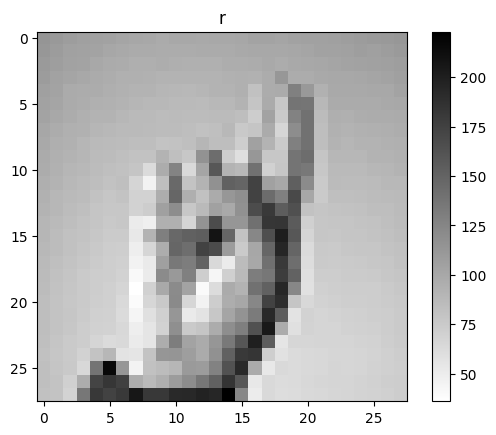

In [ ]:
# 아래 숫자를 바꿔가며 화면에 그려 봅시다.
n = 100
sign_fig = data.iloc[n, 1:].values
sign_fig = sign_fig.reshape(28, 28)

sign = class_names[data.iloc[n,0]]

plt.title(sign)
plt.imshow(255-sign_fig, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

## 3.데이터 준비

* 주어진 데이터셋
    * 2차원 데이터셋, 1차원 데이터포인트(분석단위, 예측단위) 입니다.
    * 흑백 이미지데이터
    * 이 데이터로부터 데이터 준비작업을 수행합니다.
        * 데이터 분할1 : x, y
        * 데이터 분할2 : train, validation
        * 만약 CNN으로 모델링을 한다면, shape를 맞춰야 합니다. (n, 28, 28, 1)
        * scaling
* 그러나 운영에서 발생될 데이터는 이미지 한장 한장 입니다. 이미지 한장, 한장 들어온다면 어떻게 데이터가 처리되어야 할까요?(Data Pipeline 구성)

### (1) 데이터 분할1 : x, y 나누기

In [ ]:
target = 'label'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (2) 데이터 분할2 : train, validation

* train : val : test = 5000 : 2000 : 1000
* 여기서 test set은 파이프라인 점검을 위한 용도로 사용합니다.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1000, random_state = 20)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 2000, random_state = 20)

In [ ]:
x_train.shape, x_val.shape, x_test.shape

((5000, 784), (2000, 784), (1000, 784))

In [ ]:
# 모두 넘파이로 변환
x_train, x_val, y_train, y_val = x_train.values, x_val.values, y_train.values, y_val.values

### (3) shape 맞추기 n, 28,28,1

* reshape
    * x_train.shape : (-1, 28, 28, 1)
    * x_val.shape : (-1, 28, 28, 1)

In [ ]:
x_train = x_train.reshape(5000,28,28,1)
x_val = x_val.reshape(2000,28,28,1)

In [ ]:
x_train.shape, x_val.shape

((5000, 28, 28, 1), (2000, 28, 28, 1))

### (4) Scaling : Min-Max

* 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
* x_train, x_test를 그냥 255로 나누면 됨

In [ ]:
x_train = x_train / 255.
x_val = x_val / 255.

## 4.모델링

### (1) 모델 설계

In [ ]:
clear_session()

model = Sequential([Conv2D(16, kernel_size=3, input_shape=(28, 28, 1), padding='same', strides =1, activation='relu'),
                    MaxPooling2D(pool_size=2, strides=2),
                    Flatten(),
                    Dense(128, activation = 'relu'),
                    Dense(26, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               401536    
                                                                 
 dense_1 (Dense)             (None, 26)                3354      
                                                                 
Total params: 405050 (1.55 MB)
Trainable params: 405050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

### (2) 학습

In [ ]:
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy')

history = model.fit(x_train, y_train, epochs = 10, validation_split=0.2).history

Epoch 1/10
125/125 [==============================] - 3s 20ms/step - loss: 3.0479 - val_loss: 2.7392
Epoch 2/10
125/125 [==============================] - 3s 28ms/step - loss: 2.2490 - val_loss: 1.7942
Epoch 3/10
125/125 [==============================] - 3s 21ms/step - loss: 1.5419 - val_loss: 1.3589
Epoch 4/10
125/125 [==============================] - 2s 17ms/step - loss: 1.1102 - val_loss: 0.9675
Epoch 5/10
125/125 [==============================] - 2s 17ms/step - loss: 0.8375 - val_loss: 0.7374
Epoch 6/10
125/125 [==============================] - 2s 17ms/step - loss: 0.6660 - val_loss: 0.6338
Epoch 7/10
125/125 [==============================] - 3s 21ms/step - loss: 0.5175 - val_loss: 0.4997
Epoch 8/10
125/125 [==============================] - 4s 29ms/step - loss: 0.4151 - val_loss: 0.4117
Epoch 9/10
125/125 [==============================] - 4s 30ms/step - loss: 0.3357 - val_loss: 0.3801
Epoch 10/10
125/125 [==============================] - 3s 23ms/step - loss: 0.2794 - val_lo

### (3) 학습결과 그래프

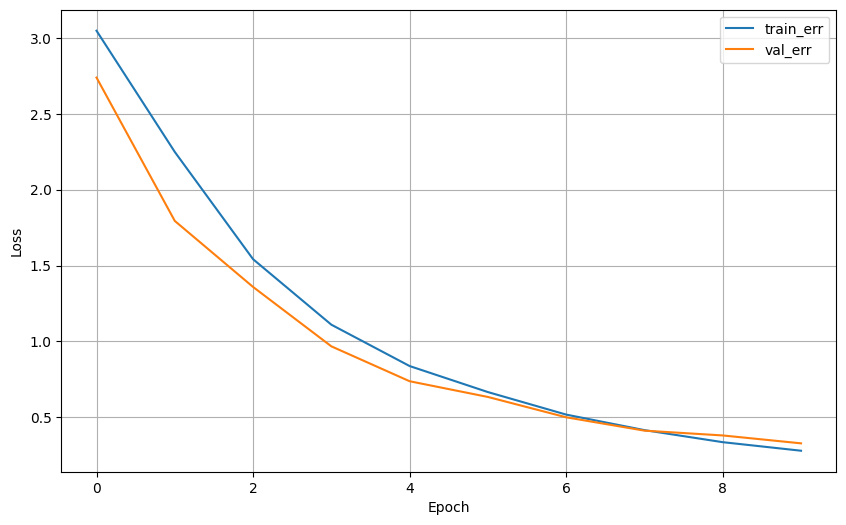

In [ ]:
dl_history_plot(history)

### (4) 예측 및 검증

In [ ]:
pred = model.predict(x_val)

63/63 [==============================] - 0s 6ms/step


In [ ]:
pred_1 = pred.argmax(axis=1)

In [ ]:
print(accuracy_score(y_val,pred_1))
print('-'*60)
print(confusion_matrix(y_val, pred_1))

0.902
------------------------------------------------------------
[[75  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0 64  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 68  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 90  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  4  0]
 [ 0  0  0  0 62  0  0  0  0  0  0  3  2  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0 98  0  0  0  0  0  0  0  0  0  0  1  0  2  0  0  2  0  0]
 [ 0  0  0  0  0  0 79  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  4 72  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  4]
 [ 0  0  0  0  0  0  0  0 79  1  0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  1 74  0  0  0  0  1  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 85  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  0  0 79  0  0  0  1  0 10  0  0  0  0  0  0]
 [ 2  0  0  0  3  0  0  0  0  0  

In [ ]:
print(classification_report(class_names[y_val], class_names[pred_1]))

              precision    recall  f1-score   support

           a       0.94      0.97      0.96        77
           b       0.98      1.00      0.99        64
           c       1.00      0.99      0.99        69
           d       0.98      0.94      0.96        96
           e       0.94      0.90      0.92        69
           f       0.98      0.95      0.97       103
           g       0.82      0.99      0.90        80
           h       0.99      0.89      0.94        81
           i       0.98      0.93      0.95        85
           k       0.70      0.91      0.80        81
           l       0.88      0.99      0.93        86
           m       0.80      0.85      0.82        93
           n       0.93      0.75      0.83        71
           o       0.99      0.94      0.96        87
           p       0.95      0.96      0.96        84
           q       0.99      0.98      0.98        94
           r       0.72      0.82      0.77        89
           s       0.76    

## 5.저장하기

* 여기서는 joblib을 이용하여 모델과 데이터셋을 저장하겠습니다.

### (1) 모델 저장하기

In [ ]:
joblib.dump(model, 'model.pkl')

['model.pkl']

### (2) 모델 로딩하기
* 로딩시 model2로 저장합니다.

In [ ]:
model2 = joblib.load('model.pkl')

### (3) test 셋으로 예측하고 평가해보기

* test 셋에 필요한 전처리는 다음과 같습니다.
    * 넘파이 어레이로 변환
    * 4차원 데이터셋으로 변환
    * 스케일링

In [ ]:
# 넘파이 어레이로 변환
new_dataset = x_test.values

# 4차원 데이터셋
new_dataset = new_dataset.reshape(-1, 28, 28, 1)

# 스케일링
new_dataset = new_dataset / 255

In [ ]:
# 예측하고 평가하기
pred = model2.predict(new_dataset)
pred_1 = pred.argmax(axis=1)

print(accuracy_score(y_test, pred_1))
print('-'*60)
print(confusion_matrix(y_test, pred_1))
print('-'*60)
print(classification_report(class_names[y_test], class_names[pred_1]))

32/32 [==============================] - 0s 6ms/step
0.898
------------------------------------------------------------
[[45  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 41  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0 31  0  0  0  0  0  0  2  2  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0 39  0  0  0  0  0  0  0  0  2  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 38  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0  0 40  0  0  0  0  0  3

## 6.Data Pipeline 구성

### (1) 라이브러리 로딩

In [ ]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

### (2) 테스트 데이터 로딩
* 제공받은 이미지로 테스트 해보기
* 직접 찍은 사진으로 테스트 해보기

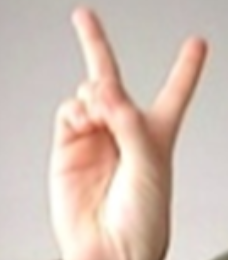

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

path = '/content/drive/MyDrive/미니프로젝트/7차/2023.11.30_미니프로젝트 7차_2일차 실습자료/test image/'
file = 'v.png'
filename = path + file

img = cv2.imread(filename)
cv2_imshow(img)

### (3) Data Pipeline에 포함되어야 할 절차
* 이미지 크기 맞추기
* 흑백이미지
* 스케일링

#### 1)이미지 읽을 때 흑백으로 읽기

(260, 228)


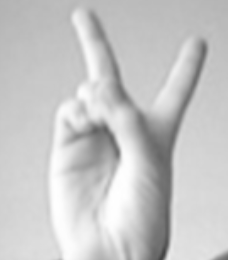

In [ ]:
# 파일 열기
img = cv2.imread(filename , cv2.IMREAD_GRAYSCALE)

# 조회는 파이프라인 불필요
print(img.shape)
cv2_imshow(img)


#### 2)이미지 크기를 28, 28, 1 로 맞추기
* 이미지 크기를 조절하는 방법은 크게 두가지 입니다.
    * numpy
    * opencv의 resize 함수 이용

In [ ]:
# 크기 조절하기
img = cv2.resize(img, (28, 28))

# 조회는 파이프라인 불필요
print(img.shape)
cv2_imshow(img)


(28, 28)


In [ ]:
# 입력데이터 형식을 갖추기
test_sign = img.reshape(1,28,28,1)

#### 3)스케일링

In [ ]:
test_sign = test_sign / 255.

#### 4)모델 로딩하기

In [ ]:
model2 = joblib.load('model.pkl')

#### 5)예측하기

In [ ]:
pred = model2.predict(test_sign)
pred_1 = pred.argmax(axis=1)
print(class_names[pred_1])

1/1 [==============================] - 0s 72ms/step
['v']


### (4) 하나의 셀로 합치기

* 폴더 구조를 만들어 놓고 개발하기 필요한 코드를 하나로 모으기

In [ ]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

# class names 준비
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)

# 파일 로딩
file = '/content/drive/MyDrive/미니프로젝트/7차/2023.11.30_미니프로젝트 7차_2일차 실습자료/test image/v.png'

# 흑백으로 읽기
img = cv2.imread(file , cv2.IMREAD_GRAYSCALE)

# 크기 조정
img = cv2.resize(img, (28, 28))

# input shape 맞추기
test_sign = img.reshape(1,28,28,1)

# 스케일링
test_sign = test_sign / 255.

# 모델 로딩
model2 = joblib.load('model.pkl')

# 예측
pred = model.predict(test_sign)
pred_1 = pred.argmax(axis=1)
print(class_names[pred_1])

1/1 [==============================] - 0s 31ms/step
['v']
